# Simple Least Cost Path Analysis

## 1. Create a grid using numpy array

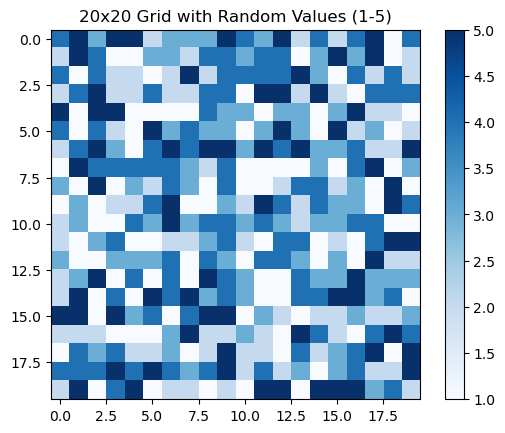

In [57]:
import numpy as np

# create a grid (all zeros)
grid_size = (20, 20)
grid = np.zeros(grid_size, dtype=float)

# optional: create coordinate matrices if you need indices for each cell
x = np.arange(grid_size[1])
y = np.arange(grid_size[0])
X, Y = np.meshgrid(x, y)

# assign a random value (1-5, int) to each cell
# set random seed for reproducibility
np.random.seed(42)
grid = np.random.randint(1, 6, size=grid_size)

# Visualize the grid using matplotlib
import matplotlib.pyplot as plt
plt.imshow(grid, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title(f'{grid_size[0]}x{grid_size[1]} Grid with Random Values (1-5)')
plt.show()

## 2. Randomly assign start and destination cells

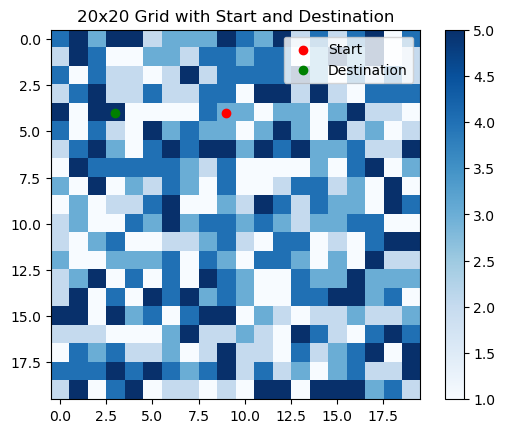

In [62]:
# Randomly assign start and destination cells
start = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))
destination = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))

# Ensure start and destination are not the same
while start == destination:
    destination = (np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1]))

# Visualize start and destination on the grid
im = plt.imshow(grid, cmap='Blues', interpolation='nearest')
plt.scatter(*start[::-1], color='red', label='Start')
plt.scatter(*destination[::-1], color='green', label='Destination')
plt.colorbar(im)  # Pass the image to colorbar
plt.title(f'{grid_size[0]}x{grid_size[1]} Grid with Start and Destination')
plt.legend()
plt.show()

## 3. Find the least cost path between start and destination

In [63]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

# Convert the grid to a graph
def grid_to_graph(grid) -> csr_matrix:
    """
    Convert a 2D cost grid into a sparse adjacency graph (CSR matrix).

    Each grid cell becomes a node. Edges connect 4-neighbors (up, down, left, right).
    The weight of an edge from cell A to neighbor B is the cost of entering B
    (i.e., the value stored in the neighbor cell).

    Parameters
    ----------
    grid : numpy.ndarray
        2D array of non-negative costs (shape: rows x cols).

    Returns
    -------
    scipy.sparse.csr_matrix
        Sparse adjacency matrix of shape (n, n) where n = rows * cols.
        Entry (i, j) is nonzero if node i has an edge to node j, and its value
        is the cost to move from i into j.
    """
    rows, cols = grid.shape
    n = rows * cols
    data = []
    row_ind = []
    col_ind = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4 neighbors
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    nidx = nr * cols + nc
                    data.append(grid[nr, nc])
                    row_ind.append(idx)
                    col_ind.append(nidx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(n, n), dtype=grid.dtype)

graph = grid_to_graph(grid)
# print numbers of nodes and edges
print(f'Graph has {graph.shape[0]} nodes and {graph.nnz} edges')

Graph has 400 nodes and 1520 edges


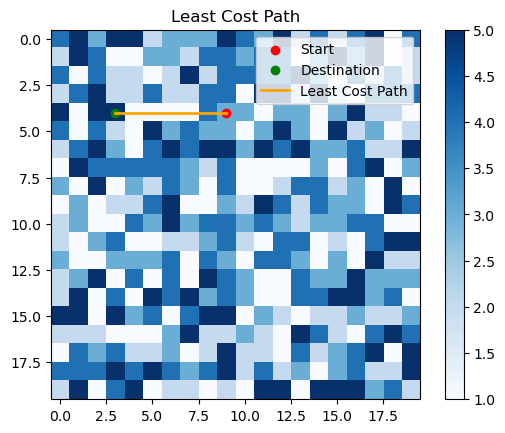

In [64]:
graph = grid_to_graph(grid)
start_idx = start[0] * grid.shape[1] + start[1]
dest_idx = destination[0] * grid.shape[1] + destination[1] # index of destination in the graph in 1D

# Dijkstra’s algorithm: compute shortest path from start to all other nodes
# return both the distance matrix (1D array) and the predecessors matrix (1D array)
dist_matrix, predecessors = shortest_path(graph, directed=False, indices=start_idx, return_predecessors=True)

# use predecessors to reconstruct the path from start to destination
path = []
i = dest_idx
if np.isfinite(dist_matrix[dest_idx]):
    while i != start_idx:
        path.append((i // grid.shape[1], i % grid.shape[1])) # trace back the path from destination to start
        # print( i // grid.shape[1], i % grid.shape[1])
        i = predecessors[i]
    path.append(start)
    path = path[::-1]
else:
    path = None

# Visualize the path
im = plt.imshow(grid, cmap='Blues', interpolation='nearest')
plt.scatter(*start[::-1], color='red', label='Start')
plt.scatter(*destination[::-1], color='green', label='Destination')
if path:
    y, x = zip(*path)
    plt.plot(x, y, color='orange', linewidth=2, label='Least Cost Path')
plt.colorbar(im)
plt.title('Least Cost Path')
plt.legend()
plt.show()

## Note: Sparse Matrix

In [67]:
from scipy.sparse import csr_matrix
dense = [[0, 0, 3],
         [4, 0, 0],
         [0, 0, 0]]
sparse = csr_matrix(dense)
print(sparse)

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 2 stored elements and shape (3, 3)>
  Coords	Values
  (0, 2)	3
  (1, 0)	4
